### Note: This assignment will extensively refer to coding exercise in assignment 4.

## 6.2.a Building your own Neural-Network

Import numpy, which is really all we need to create our own NN.

In [1]:
import numpy as np
# Remember to Fix your seeds for pytorch and numpy
import torch
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Recall that our simple neural network consisted of two layers. We also added an `activation` function as a non-linearity to the output of our intermediate layer. Given an input $\mathbf{x} \in \mathbb{R}^n $ we have

$ \mathbf{h} = f^{(1)}(\mathbf{x}; \mathbf{W},c) = activation\_fn(\mathbf{W}^\mathsf{T} \mathbf{x} + c) $ 

$ \mathbf{y} = f^{(2)}(\mathbf{h}; \mathbf{w},b) = \text{$ softmax $}( \mathbf{w}^\mathsf{T} \mathbf{h} + b) $

In this exercise you will create your own network and are free to implement it with your own design choices. However, we will do it in a way that allows you to specify the depth of network, i.e. we extend our network such that there isn't just one $\mathbf{h}$ intermediate layers, but rather $n$ of them $\mathbf{h}_{i}$ with $i \in \{1,..., n\}$

**NOTE**: You are not allowed to use any built-in functions to calculate Leaky_ReLU, Softmax or the forward/backward pass directly.

**NOTE 2**: Remember to include the non-linearity at every layer. Remember to also add the bias to every layer. Finally, remember to apply the softmax in the output layer.

## ToDo: Rewrite the Leaky_ReLu and Softmax function as Class and implement a function in each of them to calculate gradients (1 point)
Remember that in PyTorch, these are implemented as classes so we also want to have them as classes.

In [235]:
class leaky_relu:
    """
    Recall your implementation of relu function in assignment 4 and try to implement
    Leaky_ReLu similarily, but as a class with a function to calculate gradient
    """
    # TODO: Implement
    def __init__(self):
        self.leak = 0.1

    def __call__(self, x):
      return self.forward(x)


    def forward(self, x):
        self.x = x
        return x * (x > 0) + x * self.leak * (x < 0)
    
    def backward(self):
        x = self.x
        return (x > 0) + self.leak * (x < 0)


In [236]:
class softmax:
    """
    Recall your implementation of softmax function in assignment 4 and try to implement
    softmax similarily, but as a class with a function to calculate gradient
    """
    # TODO: Implement

    def __call__(self, x):
      return self.forward(x)


    def forward(self, x):
        self.x = x
        return np.exp(x)/sum(np.exp(x))

    
    def backward(self):
        x = self.x
        jacobian_m = np.diag(x)
        
        for i in range(len(jacobian_m)):
            for j in range(len(jacobian_m)):
                if i == j:
                    jacobian_m[i][j] = x[i] * (1 - x[i])
                else: 
                    jacobian_m[i][j] = -x[i]* x[j]
        
        return jacobian_m

## ToDo: Calculate the gradient using your implemented functions in their respective classes and validate by manually calculating gradients using a toy value. (1 point)

In [248]:
## Solution

lr_layer = leaky_relu()
print(lr_layer.forward(10))
print(lr_layer.backward()) # I believe it is obvious for leaky relu
print(lr_layer.forward(-10))
print(lr_layer.backward()) # it is set to have 0.1 leakage for negative values 


inp = torch.Tensor([1,1,1])

sm_layer = softmax()
print(sm_layer.forward(inp))  # since softmax gives each one a probability with respect to their value, it is expected to print .3 .3 .3 since all of them have the same value
sm = torch.nn.Softmax(0)
print(sm(inp))
sm_layer.backward()

10.0
1.0
-1.0
0.1
tensor([0.3333, 0.3333, 0.3333])
tensor([0.3333, 0.3333, 0.3333])


array([[ 0., -1., -1.],
       [-1.,  0., -1.],
       [-1., -1.,  0.]], dtype=float32)

## ToDo: Rewrite the code from Assignment 4 to include backpropagation in your class without using pytorch. Remember to use your Leaky_ReLu class here as activation function. (1.5 points)
#### Feel free to refer to your solutions from Assignment 4.

In [286]:
class Layer:
    def __init__(self, size, index, activation='leaky_relu'):
        self.size = size 
        self.layer_index = index 
        self.a = 0 
        self.z = 0 
        self.act = leaky_relu() if activation == 'leaky_relu' else softmax()
        
    def init_weight(self, input_shape, output_shape):
        mean = 0
        std = np.sqrt(2/(input_shape + output_shape))
        self.weights = np.float32(np.random.uniform(-std, std, (output_shape, input_shape)))
        self.bias = np.float32(np.random.uniform(-std, std, (output_shape,1)))
    
    def activation(self, inputs):
        self.z = np.dot(self.weights,inputs) + self.bias
        self.a = self.act(self.z)
        return self.a
    
    def activation_grad(self):
        return self.act.backward()


class FFNetwork:
    """
    Class representing the feed-forward neural network
    """
    def __init__(self, input_dim: int, hidden_dim: int,
                 output_dim: int, hidden_size: int):
        """
        Args:
        input_dim: dimensionality of `x`
        hidden_dim: dimensionality of the intermediate `h_i`
        output_dim: dimensionality of `y`
        hidden_size: number of intermediate layers `h_i`
        """
        # TODO: Implement
        # Initialize each layer as a random matrix of the
        # appropriate dimensions
        
        ## SOLUTION ##
        self.lrelu = leaky_relu()
        self.softmax = softmax()
        self.hidden_size = hidden_size
        self.layers = []


        input_layer = Layer(input_dim, 0)
        input_layer.init_weight(28*28, hidden_dim)
        self.layers.append(input_layer)

        
        for i in range(hidden_size):
            hidden_layer = Layer(hidden_dim, i+1)
            hidden_layer.init_weight(hidden_dim, hidden_dim)
            self.layers.append(hidden_layer)
        

        output_layer = Layer(output_dim, hidden_size+1, 'softmax')
        output_layer.init_weight(hidden_dim, output_dim)
        self.layers.append(output_layer)

    def forward_propogation(self, Xs):
        results = []
        for X in Xs:
            a = X
            for layer in self.layers:
                a = layer.activation(a)
            results.append(a)
        return results
    
    def backpropogate(self, Xy):
        X, y = Xy
        delta = list()
        delta_w = [0 for _ in range(len(self.layers))]
        delta_b = [0 for _ in range(len(self.layers))]
        error_o = (self.layers[-1].z - y.T.detach().numpy())
        for i in reversed(range(len(self.layers) - 1)):
            error_i = np.multiply(self.layers[i+1].weights.T.dot(error_o), self.layers[i].activation_grad())
            delta_w[i+1] = error_o.dot(self.layers[i].a.T)/len(y)
            delta_b[i+1] = np.sum(error_o, axis=1, keepdims=True)/len(y)
            error_o = error_i
        delta_w[0] = error_o.dot(X)
        delta_b[0] = np.sum(error_o, axis=1, keepdims=True)/len(y)
        return (delta_w, delta_b)
        

In [287]:
model = FFNetwork(28*28, 100, 10, 10)

In [288]:
model.layers

In [289]:
import torch
import torch.nn.functional as F
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as T

dataset_flatten = MNIST(root='.', download=True, transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))]))
data_loader = torch.utils.data.DataLoader(dataset_flatten,
                                          batch_size=1,
                                          shuffle=True)

In [290]:
data = next(iter(data_loader))
res = model.forward_propogation(torch.Tensor(data[0]))

In [292]:
model.backpropogate(data)

ValueError: ignored

### 6.2.b.2 Training a network for MNIST (1.5 points)

Now that we know how to train a Neural network in Pytorch. Let's start training and evaluating our model using a very standard dataset, for now let's use MNIST. Design a network from scracth using PyTorch and include the followings. Remember that we need to use forward-propagation and backprop.
- Training Loop
- Optimization 
- Evaluating Loop

In [94]:
import torch
import torch.nn.functional as F
import torchvision

from torch import nn
from torch.utils.data import DataLoader

In [95]:
class TorchFFNetwork(nn.Module):
    """
    A pytorch implementation to do classification for MNIST dataset.
    """
    def __init__(self, n_layers, n_neurons):
        super(TorchFFNetwork, self).__init__()

        self.n_layers = n_layers
        self.n_neurons = n_neurons

        setattr(self, 'input_layer', nn.Linear(784, self.n_neurons))
        
        for i in range(n_layers):
            setattr(self, f'hidden_{i}', nn.Linear(n_neurons, n_neurons, bias=True))
        
        setattr(self, 'output_layer', nn.Linear(n_neurons, 10))

        self.lrelu = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):
      outputs = list()
      for x in inputs:
        
        x = getattr(self, 'input_layer')(x)

        for i in range(self.n_layers):
          x = getattr(self, f'hidden_{i}')(x)
          x = self.lrelu(x)

        x = getattr(self, 'output_layer')(x)
        outputs.append(self.softmax(x))
      return outputs

In [96]:
model = TorchFFNetwork(2, 20)
loss_function = nn.CrossEntropyLoss()
size=60000
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [97]:
from torchvision.datasets import MNIST
import torchvision.transforms as T

dataset_flatten = MNIST(root='.', download=True, transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))]))

In [98]:
data_loader = torch.utils.data.DataLoader(dataset_flatten,
                                          batch_size=10,
                                          shuffle=True)

In [99]:
losses = []
for i in range(10):
  for batch, (X, y) in enumerate(data_loader):
      # Compute prediction and loss
      pred = model(X)
      loss = loss_function(torch.stack(pred), torch.eye(10)[y-1])

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 100 == 0:
          loss, current = loss.item(), batch * len(X)
  print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  losses.append(loss)


loss: 2.241408  [59000/60000]
loss: 1.812950  [59000/60000]
loss: 1.920570  [59000/60000]
loss: 1.725190  [59000/60000]
loss: 1.739768  [59000/60000]
loss: 1.645784  [59000/60000]
loss: 1.762018  [59000/60000]
loss: 1.685298  [59000/60000]
loss: 1.665389  [59000/60000]
loss: 1.463155  [59000/60000]


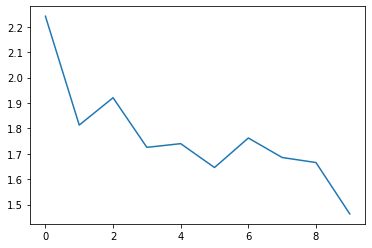

In [105]:
import matplotlib.pyplot as plt
l = []
for i in losses:
  l.append(i.detach().numpy())
plt.plot(l)
plt.show()

### ToDo: Implement functions for Stochastic Gradient Descent and Stochastic Gradient Descent with momentum and plot the difference on how they change the value for gradients. ( 1 + 1 (Bonus))

In [106]:
model = TorchFFNetwork(5, 10)
loss_function = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer_momentum = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.01)

In [107]:
data_loader = torch.utils.data.DataLoader(dataset_flatten,
                                          batch_size=16,
                                          shuffle=True)

In [140]:
losses = []
grad_sums = []
for i in range(10):
  for batch, (X, y) in enumerate(data_loader):
      # Compute prediction and loss
      X.requires_grad = True
      pred = model(X)
      loss = loss_function(torch.stack(pred), torch.eye(10)[y-1])

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 100 == 0:
          loss, current = loss.item(), batch * len(X)
          grad_sums.append(X.grad)
  print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  losses.append(loss)


loss: 0.091056  [59200/60000]
loss: 0.090390  [59200/60000]
loss: 0.088841  [59200/60000]
loss: 0.089581  [59200/60000]
loss: 0.090674  [59200/60000]
loss: 0.090059  [59200/60000]
loss: 0.089975  [59200/60000]
loss: 0.089553  [59200/60000]
loss: 0.089374  [59200/60000]
loss: 0.090438  [59200/60000]


In [141]:
model = TorchFFNetwork(5, 10)

losses_momentum = []
grad_sums_momentum = []
for i in range(10):
  for batch, (X, y) in enumerate(data_loader):
      # Compute prediction and loss
      X.requires_grad = True
      pred = model(X)
      loss = loss_function(torch.stack(pred), torch.eye(10)[y-1])

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer_momentum.step()

      if batch % 100 == 0:
          loss, current = loss.item(), batch * len(X)
          grad_sums_momentum.append(X.grad)
  print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  losses_momentum.append(loss)


loss: 0.090481  [59200/60000]
loss: 0.090107  [59200/60000]
loss: 0.090832  [59200/60000]
loss: 0.090323  [59200/60000]
loss: 0.090350  [59200/60000]
loss: 0.089464  [59200/60000]
loss: 0.090041  [59200/60000]
loss: 0.090128  [59200/60000]
loss: 0.089673  [59200/60000]
loss: 0.089936  [59200/60000]


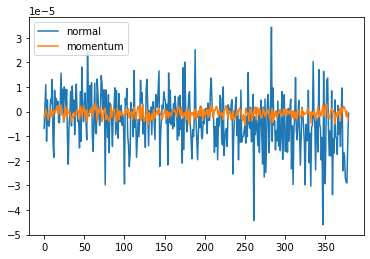

In [149]:
import matplotlib.pyplot as plt
l = []
for i in grad_sums:
  l.append(sum(sum(i.detach().numpy())))
l_m = []
for i in grad_sums_momentum:
  l_m.append(sum(sum(i.detach().numpy())))

plt.plot(l, label="normal")
plt.plot(l_m, label="momentum")
plt.legend(loc="upper left")
plt.show()

# I am not sure how exactly you want me to compare grads but as you can see, 
# grads are much more stable with momentum compared to normal. 
# Both have converged very early so we can not see them decrease much.

In [138]:
sum(sum(grad_sums[0]))

tensor(-1.1852e-06)